# Word Embedding

Word Embedding is a type of word representation that allows words with similar meaning to have a similar representation. It is a learned representation for text where words that have the same meaning have a similar representation. The process of creating word embeddings is to train a model on a large body of text using unsupervised learning so that it learns to predict a word given its context, or vice versa. This results in embeddings where words that are close together in the high-dimensional embedding space are expected to be semantically similar.

Notably, word embeddings do not just assign each word to a unique vector, but they actually represent words in a way that captures semantic or syntactic similarity, based on the text corpus the model is trained on. Embedding vectors are often hundreds of dimensions and are good at capturing nuanced relationships between words.

![word_embed](../asset/word_embed.png)

## Embedding layer

An Embedding Layer in machine learning is a layer that creates word embeddings from input sequences by mapping words or integers to dense vectors of real numbers. It's often used in natural language processing tasks where the layer takes in a 2D input of integer sequences (word indices) and on output provides 3D floating point tensor sequences. Each individual sequence in the 3D output tensor will have the same length as the original input sequence, but each word or integer in the sequence is now represented by a dense vector. These vectors capture semantic relationships between words, and their dimensionality is a hyperparameter that can be tuned for specific tasks.

### Very basic usage

Embedding is just a simple lookup table. Link a index to a trainable vector.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import torch
import torch.nn as nn

word_to_ix = {"hello": 0, "world": 1}

# 2 words in vocab "hello" and "world"
# 5 dimensional embeddings
embeds = nn.Embedding(num_embeddings=2, embedding_dim=5)

lookup_tensor = torch.tensor([word_to_ix["hello"]], dtype=torch.long)

hello_embed = embeds(lookup_tensor)

print(hello_embed)

tensor([[ 1.3933, -0.5797, -0.4585,  1.1172,  0.1074]],
       grad_fn=<EmbeddingBackward0>)


Get train parameters


In [3]:
for param in embeds.parameters():
    print(param)

Parameter containing:
tensor([[ 1.3933, -0.5797, -0.4585,  1.1172,  0.1074],
        [-0.7213,  0.0032,  0.6258,  0.2680,  0.8619]], requires_grad=True)


Just for fun set weight to a fix value


In [4]:
embedding_lookup = torch.tensor([
    [1, 0, 0, 0, 1],
    [0, 1, 1, 1, 0],
], dtype=torch.float32)
embeds.weight = nn.Parameter(embedding_lookup)
embeds.weight

Parameter containing:
tensor([[1., 0., 0., 0., 1.],
        [0., 1., 1., 1., 0.]], requires_grad=True)

As you can see, if I select index 0 or 1, I get my embedding_lookup line.


In [5]:
print(embeds(torch.tensor([0])))
print(embeds(torch.tensor([1])))

tensor([[1., 0., 0., 0., 1.]], grad_fn=<EmbeddingBackward0>)
tensor([[0., 1., 1., 1., 0.]], grad_fn=<EmbeddingBackward0>)


## GPT embedding

Let's get the very first GPT model and see how the embedding layer size

In [6]:
from transformers import GPT2Tokenizer, GPT2Model

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2Model.from_pretrained("gpt2")

inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")

print("vocab size", tokenizer.vocab_size)

# expected Embedding(50257, 768)
# 50257 = vocabulary size
# 768 = number of features
print("Embedding size", model.wte)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab size 50257
Embedding size Embedding(50257, 768)



[Let's look at the code for this model](https://github.com/huggingface/transformers/blob/v4.25.1/src/transformers/models/gpt2/modeling_gpt2.py#L667)

## Train first embedding layer

For this part we will train our first embedding layer on disney park reviews !

To start we will ony train this layer on letter instance of words



In [7]:
import pandas as pd

# Load and take subset of the dataset
df = pd.read_csv("/content/drive/MyDrive/🌍PUBLIC SHARED/disney_review/train.csv")[:5000]
df.head()

,Unnamed: 0,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch
0,16833,333121929,5,2015-12,United States,Truly the most magical place on the West Coast...,Disneyland_California
1,28602,71690002,5,missing,Canada,"I cry every time we have to leave this place, ...",Disneyland_California
2,32094,481683772,5,2017-4,United Kingdom,"Staff everywhere were just friendly, the custo...",Disneyland_Paris
3,16576,339637317,5,2016-1,United States,"It's Disneyland, what more is there to say? W...",Disneyland_California
4,13962,438710000,5,2016-10,United Kingdom,We visited this park at Halloween and enjoyed ...,Disneyland_California


In [8]:
# Count each deffrent values of rating
df['Rating'].value_counts()

5    2662
4    1274
3     610
2     260
1     194
Name: Rating, dtype: int64

In [9]:
# Get reviews
reviews = df["Review_Text"].values.tolist()

Now we will creat an sequence of letter based on sentences

For example:

```
aba decides a
```

will produce

```
[
  ('a', 'b'),
  ('b', 'a'),
  ('a', ' '),
  (' ', 'd'),
  ('d', 'e'),
  ('e', 'c'),
  ('c', 'i'),
  ('i', 'd'),
  ('d', 'e'),
  ('e', 's'),
  ('s', ' '),
  (' ', 'a'),
]
```

In [10]:
import itertools as it
import re


def sliding_window(txt):
    for i in range(len(txt) - 1):
        yield txt[i], txt[i + 1]

def sliding_window_padding(txt,size_input=1,size_output=1):
    for i in range(len(txt) - 1):
        a = txt[i:i+size_input]
        b = txt[i+size_input:i+size_input+size_output]
        yield a, b

window = []
for title in reviews:
    # Get only a to z and 0 to 9 letters and numerb and spaces
    title = re.sub('[^a-zA-Z0-9 ]+', '', title.lower())
    window.append(sliding_window_padding(title,size_input=3))
window = list(it.chain(*window))

# Number of window
print(len(window))
print(reviews[0])
# Get first 5 example
window[:5]

3345187
Truly the most magical place on the West Coast. This is my second trip to disneyland. I absolutely love this place great for adults, kids, couples, and family. Highly recommended.


[('tru', 'l'), ('rul', 'y'), ('uly', ' '), ('ly ', 't'), ('y t', 'h')]

Now lets do a one hot encoding so a letter = an id (like sql table id)

```
{' ': 2,
 'a': 0,
 'b': 1,
 'c': 5,
 'd': 3,
 'e': 4,
 'g': 8,
 'i': 6,
 'l': 16,
 'm': 12,
 'n': 9,
 'o': 11,
 'r': 15,
 's': 7,
 't': 10,
 'u': 13,
 'y': 14}
```

In [11]:
import numpy as np
all_tokens = np.concatenate((pd.DataFrame(window)[0].unique(),pd.DataFrame(window)[1].unique()))
mapping = {c: i for i, c in enumerate(pd.Series(all_tokens).unique())}
integers_in = np.array([mapping[w[0]] for w in window])
integers_out = np.array([mapping[w[1]] for w in window])

print("Shape of input", integers_in.shape)
print("Input example", integers_in[0], integers_out[0])
print("Show generate mapping\n", mapping)

Shape of input (3345187,)
Input example 0 9244
Show generate mapping
 {'tru': 0, 'rul': 1, 'uly': 2, 'ly ': 3, 'y t': 4, ' th': 5, 'the': 6, 'he ': 7, 'e m': 8, ' mo': 9, 'mos': 10, 'ost': 11, 'st ': 12, 't m': 13, ' ma': 14, 'mag': 15, 'agi': 16, 'gic': 17, 'ica': 18, 'cal': 19, 'al ': 20, 'l p': 21, ' pl': 22, 'pla': 23, 'lac': 24, 'ace': 25, 'ce ': 26, 'e o': 27, ' on': 28, 'on ': 29, 'n t': 30, 'e w': 31, ' we': 32, 'wes': 33, 'est': 34, 't c': 35, ' co': 36, 'coa': 37, 'oas': 38, 'ast': 39, 't t': 40, 'thi': 41, 'his': 42, 'is ': 43, 's i': 44, ' is': 45, 's m': 46, ' my': 47, 'my ': 48, 'y s': 49, ' se': 50, 'sec': 51, 'eco': 52, 'con': 53, 'ond': 54, 'nd ': 55, 'd t': 56, ' tr': 57, 'tri': 58, 'rip': 59, 'ip ': 60, 'p t': 61, ' to': 62, 'to ': 63, 'o d': 64, ' di': 65, 'dis': 66, 'isn': 67, 'sne': 68, 'ney': 69, 'eyl': 70, 'yla': 71, 'lan': 72, 'and': 73, 'd i': 74, ' i ': 75, 'i a': 76, ' ab': 77, 'abs': 78, 'bso': 79, 'sol': 80, 'olu': 81, 'lut': 82, 'ute': 83, 'tel': 84, 'ely

### The dataset class
The dataset class summarizes the basic functionality of a dataset in a natural way. To define a dataset in PyTorch, we simply specify two functions: __getitem__, and __len__. The get-item function has to return the i-th data point in the dataset, while the len function returns the size of the dataset.

In [12]:
import torch.utils.data as data


class NextLetterDataset(data.Dataset):

    def __init__(self, integers_in, integers_out):
        self.integers_in = integers_in
        self.integers_out = integers_out

    def __len__(self):
        # Number of data pin dataset
        return len(self.integers_in)

    def __getitem__(self, idx):
        # Return the idx-th data point of the dataset
        # If we have multiple things to return (data point and label), we can return them as tuple
        data_point = self.integers_in[idx]
        data_label = self.integers_out[idx]
        return torch.tensor(data_point), torch.tensor(data_label, dtype=torch.long)

### Build first embedding model

We will build a simple network to do next letter prediction

![next letter](../asset/next_letter_prediction.png)

In [13]:
import torch.nn.functional as F


class NextLetterPrediction(torch.nn.Module):
    def __init__(self, vocab_size, embedding_size):
        super(NextLetterPrediction, self).__init__()
        self.embedding = torch.nn.Embedding(vocab_size, embedding_size)
        self.fc = torch.nn.Linear(embedding_size, vocab_size)

    def forward(self, x):
        x = F.relu(self.embedding(x))
        x = self.fc(x)
        return x

### Plot letter before the train

Let's plot letter embedding before to train the model

In [14]:
model = NextLetterPrediction(vocab_size=len(mapping),
                             # For X and Y plot
                             embedding_size=2)

Error in callback <function _draw_all_if_interactive at 0x79f223c5ee60> (for post_execute):


KeyboardInterrupt: 

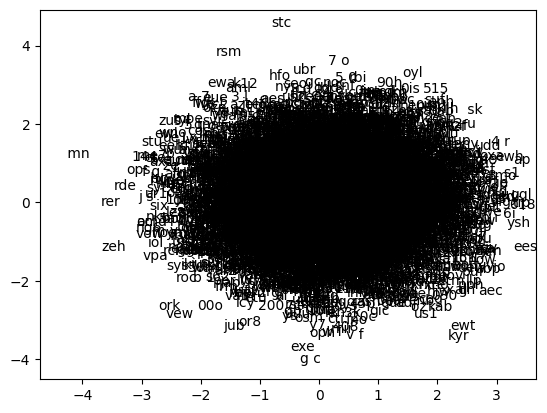

In [15]:
import matplotlib.pylab as plt

idx_to_calc = list(mapping.values())
idx_to_calc = np.array([idx_to_calc]).T

translator = {v: k for k, v in mapping.items()}
preds = model.embedding(torch.tensor(idx_to_calc)).detach().numpy()
plt.scatter(preds[:, 0, 0], preds[:, 0, 1], alpha=0)
for i, idx in enumerate(idx_to_calc):
    plt.text(preds[i, 0, 0], preds[i, 0, 1], translator[idx[0]])

### Train loop


In [16]:
# Init the dataset into the DataLoader
dataset = NextLetterDataset(integers_in, integers_out)
trainloader = data.DataLoader(dataset, batch_size=128, shuffle=True)

# Define a loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)

In [ ]:
epoches = 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# Load the model to cuda device in train mode
model.to(device)
model.train()
# loop over the dataset multiple times
for epoch in range(epoches):

    running_loss = 0.0
    for i, batch in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = batch
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:  # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

cuda
[1,  2000] loss: 3.284
[1,  4000] loss: 2.668
[1,  6000] loss: 2.649
[1,  8000] loss: 2.641
[1, 10000] loss: 2.642
[1, 12000] loss: 2.636
[1, 14000] loss: 2.639
[1, 16000] loss: 2.638
[1, 18000] loss: 2.639


In [ ]:
idx_to_calc = list(mapping.values())
idx_to_calc = np.array([idx_to_calc]).T

translator = {v: k for k, v in mapping.items()}
preds = model.embedding(torch.tensor(idx_to_calc).to(device)).cpu().detach().numpy()
plt.scatter(preds[:, 0, 0], preds[:, 0, 1], alpha=0)
for i, idx in enumerate(idx_to_calc):
    plt.text(preds[i, 0, 0], preds[i, 0, 1], translator[idx[0]])